<a href="https://colab.research.google.com/github/VarunBhardwaj03/Emotion_Detector/blob/main/notebook3cea7f05b4_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
! pip install kaggle

In [13]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [14]:
! cp kaggle.json ~/.kaggle/

In [15]:
! cp kaggle.json ~/.kaggle/

In [16]:
! kaggle datasets download jonathanoheix/face-expression-recognition-dataset


 96% 116M/121M [00:01<00:00, 111MB/s]
100% 121M/121M [00:01<00:00, 103MB/s]


In [17]:
! unzip face-expression-recognition-dataset

Streaming output truncated to the last 5000 lines.
  inflating: images/validation/fear/8797.jpg  
  inflating: images/validation/fear/8818.jpg  
  inflating: images/validation/fear/886.jpg  
  inflating: images/validation/fear/9037.jpg  
  inflating: images/validation/fear/9040.jpg  
  inflating: images/validation/fear/9101.jpg  
  inflating: images/validation/fear/911.jpg  
  inflating: images/validation/fear/9179.jpg  
  inflating: images/validation/fear/9205.jpg  
  inflating: images/validation/fear/9232.jpg  
  inflating: images/validation/fear/9251.jpg  
  inflating: images/validation/fear/9261.jpg  
  inflating: images/validation/fear/9281.jpg  
  inflating: images/validation/fear/9302.jpg  
  inflating: images/validation/fear/9333.jpg  
  inflating: images/validation/fear/9369.jpg  
  inflating: images/validation/fear/9370.jpg  
  inflating: images/validation/fear/9474.jpg  
  inflating: images/validation/fear/949.jpg  
  inflating: images/validation/fear/9602.jpg  
  inflating:

# ****IMPORTING IMPORTANT LIBRARIES****

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D

# **EXAMPLE**

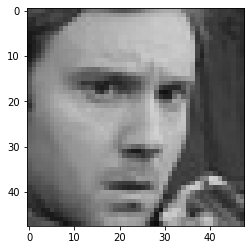

In [19]:
img_example=cv2.imread('/content/images/train/angry/0.jpg')
plt.imshow(img_example)


**SHAPE OF IMAGE**

In [20]:
img_shape=img_example.shape
img_shape

(48, 48, 3)

**CLASSES**

In [21]:
classes=[]
count=[]
for i in os.listdir("/content/images/train"):
    classes.append(i)
    count.append(len(os.listdir(os.path.join("/content/images/train",i))))
    print(i,len(os.listdir(os.path.join("/content/images/train",i))))


sad 4938
surprise 3205
disgust 436
neutral 4982
happy 7164
fear 4103
angry 3993


In [22]:
df1=pd.DataFrame()
df1['class']=classes
df1['count']=count
df1


,class,count
0,sad,4938
1,surprise,3205
2,disgust,436
3,neutral,4982
4,happy,7164
5,fear,4103
6,angry,3993


**COUNTPLOT**

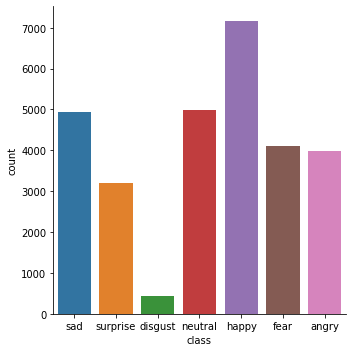

In [23]:
sns.catplot(data=df1,x="class",y="count",kind="bar")

# DATA AUGMENTATION

In [24]:
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,rotation_range=20,
                                                              data_format='channels_last',horizontal_flip=True,
                                                              width_shift_range=0.1,height_shift_range=0.1,
                                                              brightness_range=[0.2,1],shear_range=0.2,zoom_range=0.2)
test_datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# LOADING DATA

In [25]:
train_datagen=train_datagen.flow_from_directory('/content/images/train',target_size=(48,48),batch_size=64,class_mode='categorical',shuffle=True)
test_datagen=test_datagen.flow_from_directory('/content/images/validation',target_size=(48,48),batch_size=64,class_mode='categorical',shuffle=False)


Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [26]:
test_datagen.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

# LOADING SAMPLE IMAGES OF EACH CLASS

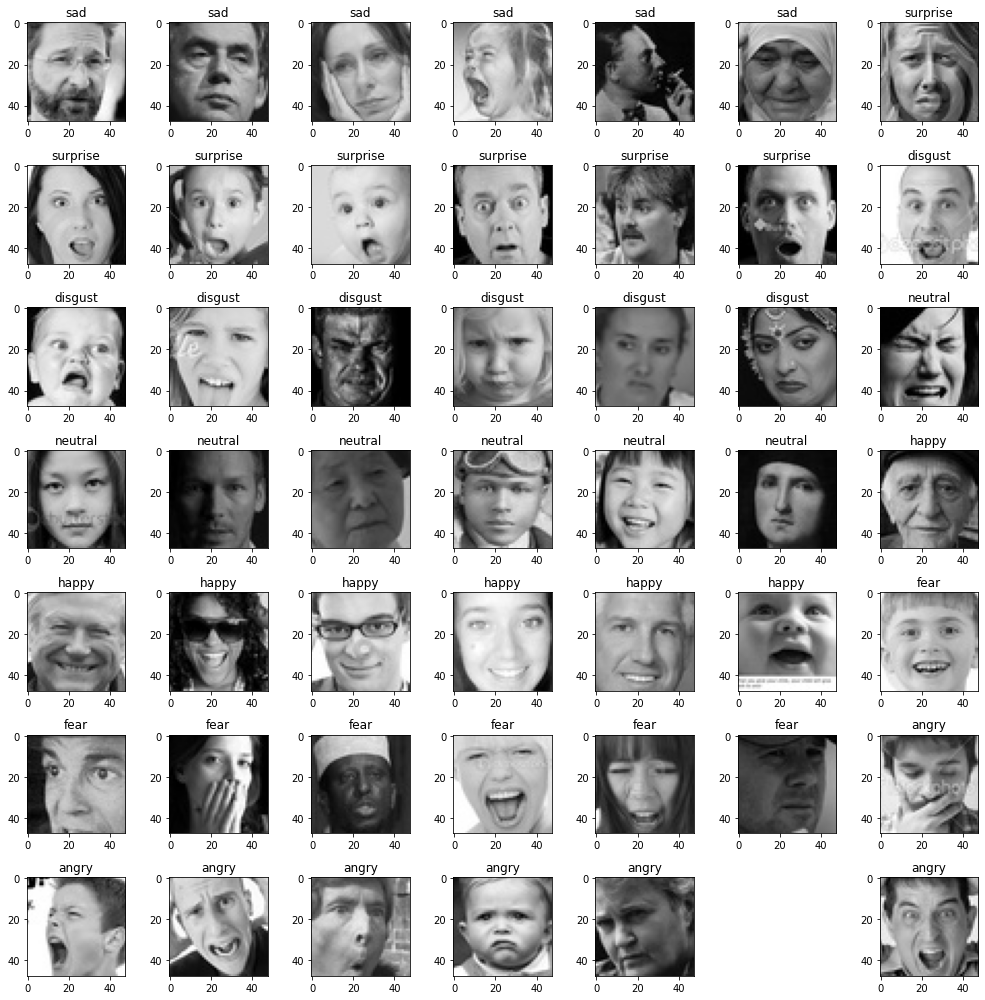

In [27]:
fig=plt.figure(1, (14, 14))
cnt=0
for param in classes:
    cnt_copy=0
    plt.title(param)
    path=os.path.join('/content/images/train',param)
    for img in os.listdir(path):
        if cnt_copy<7:
            cnt=cnt+1
            ax=plt.subplot(7,7,cnt)
            img=cv2.imread(os.path.join(path,img))
            ax.imshow(img)
            ax.set_title(param)
            plt.tight_layout()
            cnt_copy+=1
        else :
            break
            

In [28]:
batch_train=next(train_datagen)
type(train_datagen)

keras.preprocessing.image.DirectoryIterator

In [29]:
print(batch_train[0][0].shape)

(48, 48, 3)


In [30]:
type(batch_train[0])

numpy.ndarray

In [31]:
type(batch_train)

tuple

**SAMPLE IMAGES IN A SHUFFLED BATCH**

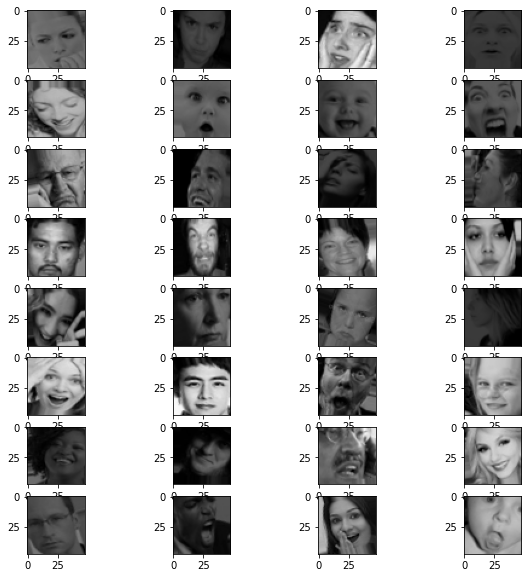

In [32]:
plt.figure(figsize=(10,10))
for i in range(32):
    plt.subplot(8,4,i+1)
    plt.imshow(batch_train[0][i])
plt.show()    
    
    

# CHECKPOINTS

In [33]:
# save_callback=tf.keras.callbacks.ModelCheckpoint(filepath='./checkpoint',save_weights_only=False,monitor='val_loss',
#                                              save_best_only=True)
# checkpoint_path="./"
# checkpoint_dir = os.path.dirname(checkpoint_path)

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


early_stop= EarlyStopping(
                                monitor = "val_accuracy",
                                min_delta=0.001,
                                patience=5,
                                verbose=1,
                                mode="max")

reduce_lr = ReduceLROnPlateau(
                                monitor="val_accuracy",
                                factor=0.1,
                                patience=2,
                                verbose=1,
                                min_delta=0.0001)

**MOBILE NET**

In [34]:
base_model=tf.keras.applications.MobileNet(include_top=False,weights='imagenet',input_shape=(48,48,3))

model=Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(7,activation='softmax'))    

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

for layers in base_model.layers:
    layers.trainable=False

model.summary()

2021-12-14 21:33:50.906004: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


17235968/17225924 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 1, 1, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                         

In [35]:
# train = train_datagen.cache().prefetch(tf.data.AUTOTUNE)
# val  = test_datagen.cache().prefetch(tf.data.AUTOTUNE)

**TRAINING MODEL**

In [36]:
history=model.fit_generator(train_datagen,validation_data=test_datagen,epochs=1,
                            steps_per_epoch=train_datagen.n//train_datagen.batch_size,
                            validation_steps=test_datagen.n//test_datagen.batch_size,verbose=1,
                            callbacks=[early_stop,reduce_lr])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


450/450 [==============================] - 515s 1s/step - loss: 1.7535 - accuracy: 0.3563 - val_loss: 1.3809 - val_accuracy: 0.4692 - lr: 0.0010


**SAVING MODEL**

# PLOTTING ACCURACY AND LOSS CURVES

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

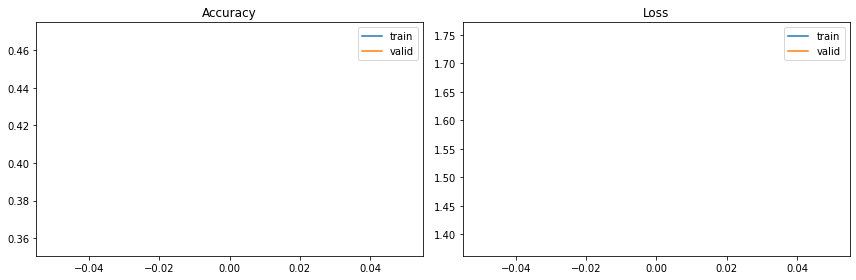

In [37]:
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.show()

In [38]:
predictions=model.predict(test_datagen, batch_size=64)
predicted_classes = np.argmax(predictions,axis=1)
true_labels=test_datagen.classes

# CONFUSION MATRIX

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.36      0.09      0.14       960
           1       0.00      0.00      0.00       111
           2       0.31      0.28      0.29      1018
           3       0.56      0.84      0.68      1825
           4       0.39      0.61      0.48      1216
           5       0.38      0.20      0.27      1139
           6       0.64      0.54      0.59       797

    accuracy                           0.47      7066
   macro avg       0.38      0.37      0.35      7066
weighted avg       0.44      0.47      0.43      7066



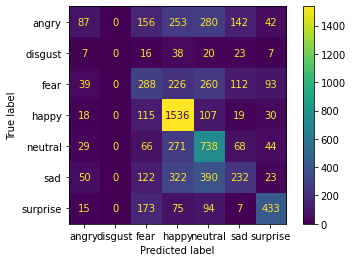

In [39]:
# import scikitplot
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred=model.predict(test_datagen)
y_pred=np.argmax(y_pred,axis=1)

cm=confusion_matrix(test_datagen.classes,y_pred)

target_names=['angry','disgust','fear','happy','neutral','sad','surprise']

print(classification_report(test_datagen.classes,y_pred))

matrix=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
matrix.plot()
plt.show()


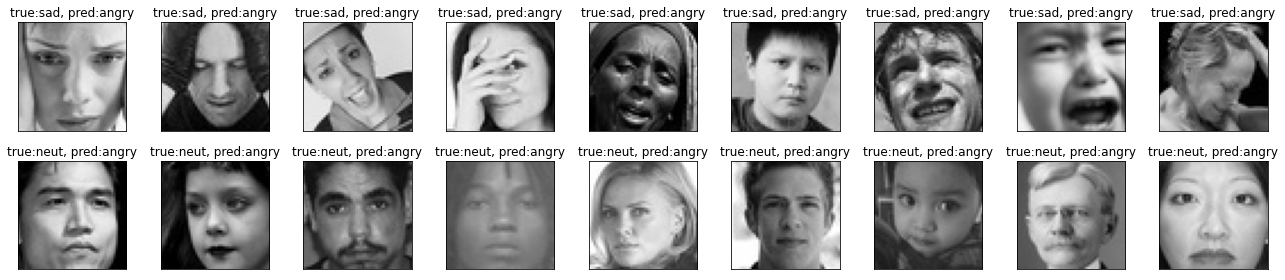

In [40]:
mapper = {0:'angry',
 1:'disgust',
 2:'fear',
 3:'happy',
 4:'neutral',
 5:'sad',
 6:'surprise'}

sad_path="/content/images/validation/sad"
neutral_path="/content/images/validation/neutral"

neutral_filenames = np.random.choice([x for x in os.listdir(neutral_path) 
                                     if os.path.isfile(os.path.join(neutral_path, x))],size=9)

sad_filenames = np.random.choice([x for x in os.listdir(sad_path) 
                                     if os.path.isfile(os.path.join(sad_path, x))],size=9)


fig = plt.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(sad_filenames, neutral_filenames)):
        ax = plt.subplot(2, 9, i+1)
        sadidx=os.path.join(sad_path,sadidx)
        sample_img = cv2.imread(sadidx)
        plt.imshow(sample_img)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:sad, pred:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,3)))]}")

        ax = plt.subplot(2, 9, i+10)
        neuidx=os.path.join(neutral_path,neuidx)
        sample_img1 = cv2.imread(neuidx)
        ax.imshow(sample_img1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:neut, pred:{mapper[np.argmax(model.predict(sample_img1.reshape(1,48,48,3)))]}")

        plt.tight_layout()


# **EFFICIENT NET**

In [41]:
# from tensorflow.keras.applications.efficientnet import EfficientNetB2
# base_model_efficientnet=EfficientNetB2(include_top=False,weights='imagenet',input_shape=(48,48,3))
# # model1=Sequential()
# # model1.add(base_model_efficientnet)
# # model1.add(Flatten())
# # model1.add(Dense(256,activation='relu'))
# # model1.add(Dense(128,activation='relu'))
# # model1.add(Dense(7,activation='softmax'))
# x=Flatten()(base_model_efficientnet.output)
# # x=Dense(256,activation='relu')(x)
# # x = keras.layers.Dropout(0.1)(x)
# # x=Dense(64,activation='relu')(x)
# # x = keras.layers.Dropout(0.1)(x)
# pred=Dense(7,activation='softmax')(x)
# model1=Model(base_model_efficientnet.input,outputs=pred)
# # when the layers arwe in a foood mooofa ehrlh ldf fhlsaa

# for layers in base_model_efficientnet.layers:
#     layers.trainable=False    
    
# model1.summary()

In [42]:
# model1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
# model1.fit_generator(train_datagen,validation_data=test_datagen,steps_per_epoch=len(train_datagen),
#                      validation_steps=len(test_datagen),
#                      epochs=1,callbacks=[early_stop,reduce_lr])

In [43]:
import pickle
pickle.dump(model,open('face_emotion.p','wb'))

2021-12-14 21:45:17.128120: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://3aa84623-5bba-499f-a744-ea89b06481b5/assets


INFO:tensorflow:Assets written to: ram://3aa84623-5bba-499f-a744-ea89b06481b5/assets


In [44]:
my_model=pickle.load(open('face_emotion.p','rb'))

In [46]:
from skimage import color
from PIL import Image
url=input("Enter the url of the image")

test_img=cv2.imread(url)
test_img=color.rgb2gray(test_img)
test_img=cv2.resize(test_img,(48,48))
test_img = np.stack((test_img,)*3, axis=-1)

# test_img=Image.open(url).convert('L')

# test_prediction=my_model.predict(test_img)
# test_prediction=np.argmax(test_prediction,axis=1)
test_prediction=mapper[np.argmax(my_model.predict(test_img.reshape(1,48,48,3)))]
print(f'PREDICTED OUTPUT : {test_prediction}')



Enter the url of the image/content/images/images/train/angry/0.jpg
PREDICTED OUTPUT : neutral


In [47]:
! pip install streamlit
! pip install pyngrok
from pyngrok import ngrok

In [48]:
!ngrok authtoken 22HtgSW3QzdSdYneqWuAjGaccOP_5J1Ssid5tr3r1S4zMhPoK


Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [49]:
!nohup streamlit run app.py &

nohup: appending output to 'nohup.out'


In [50]:
ngrok.kill()

In [10]:
# from pyngrok import ngrok
# url=ngrok.connect(port=8501)
# url

In [51]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip

--2021-12-14 21:47:32--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 18.205.222.128, 54.237.133.81, 54.161.241.46, ...
Connecting to bin.equinox.io (bin.equinox.io)|18.205.222.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  13.19M  17.1MB/s    in 0.8s    

2021-12-14 21:47:33 (17.1 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13832437/13832437]



In [52]:
!unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: ngrok                   


In [53]:
%%writefile app.py
import streamlit as st
import numpy as np
import os
import cv2
import pickle
from PIL import Image
from skimage import color
st.title("EMOTION DETECTOR")
st.text("Upload your image to predict your emotion")
my_model=pickle.load(open('face_emotion.p','rb'))
upload_file=st.file_uploader("Browse Image",type=["jpg",'png'])
if upload_file is not None:
  img=Image.open(upload_file)
  st.image(img,caption="Uploaded Image")
  if st.button("PREDICT"):
    st.write("Result....")
    img=color.rgb2gray(img)
    img=cv2.resize(img,(48,48))
    img = np.stack((img,)*3, axis=-1)

    # test_img=Image.open(url).convert('L')

    # test_prediction=my_model.predict(test_img)
    # test_prediction=np.argmax(test_prediction,axis=1)
    test_prediction=mapper[np.argmax(my_model.predict(img.reshape(1,48,48,3)))]
    st.write(f'PREDICTED OUTPUT : {test_prediction}')



Overwriting app.py


In [54]:
get_ipython().system_raw('./ngrok http 8501 &')


In [55]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    'import sys, json; print("Execute the next cell and the go to the following URL: " +json.load(sys.stdin)["tunnels"][0]["public_url"])'


Execute the next cell and the go to the following URL: https://3399-35-203-169-192.ngrok.io


In [ ]:
!streamlit run /content/app.py


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8502
  External URL: http://35.203.169.192:8502

2021-12-14 21:48:14.656014: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


NAME:
   ngrok - tunnel local ports to public URLs and inspect traffic

DESCRIPTION:
    ngrok exposes local networked services behinds NATs and firewalls to the
    public internet over a secure tunnel. Share local websites, build/test
    webhook consumers and self-host personal services.
    Detailed help for each command is available with 'ngrok help <command>'.
    Open http://localhost:4040 for ngrok's web interface to inspect traffic.

EXAMPLES:
    ngrok http 80                    # secure public URL for port 80 web server
    ngrok http -subdomain=baz 8080   # port 8080 available at baz.ngrok.io
    ngrok http foo.dev:80            # tunnel to host:port instead of localhost
    ngrok http https://localhost     # expose a local https server
    ngrok tcp 22                     # tunnel arbitrary TCP traffic to port 22
    ngrok tls -hostname=foo.com 443  # TLS traffic for foo.com to port 443
    ngrok start foo bar baz          # start tunnels from the configuration file

VERSI